In [1]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, GPT2Tokenizer

import pandas as pd
from datasets import Dataset

/home/randi_eka/anaconda3/envs/huggingface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-13 20:03:35.706454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 20:03:35.706522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 20:03:35.708278: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 20:03:35.873939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This

In [2]:
# https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Review.csv

reviews = pd.read_csv("BERT_LLM/BERT_LLM/data/data/reviews.csv")

print(reviews.shape)

reviews.head()

(96512, 3)


,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4


<Axes: title={'center': 'Histogram of Review Length'}, ylabel='Frequency'>

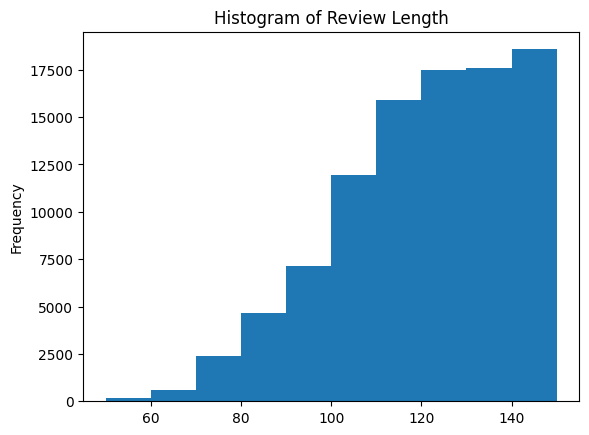

In [3]:
reviews['Text'].str.len().plot(kind = "hist", title = "Histogram of Review Length")

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

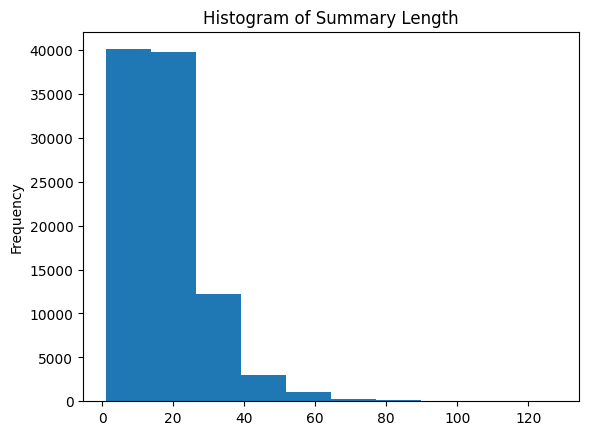

In [4]:
reviews["Summary"].str.len().plot(kind = "hist", title = "Histogram of Summary Length")

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

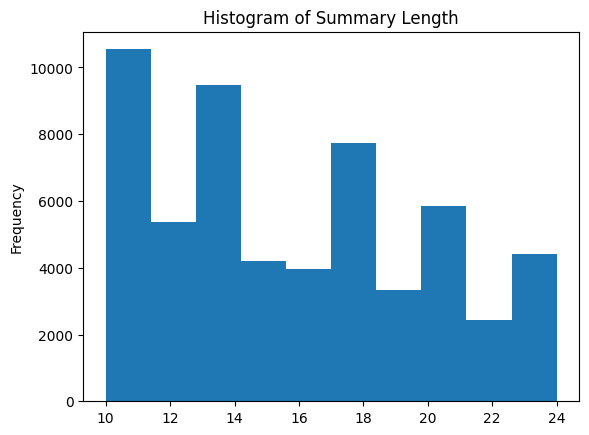

In [5]:
# remove very short and very long summaries
reviews = reviews[(reviews['Summary'].str.len() >=10) & (reviews['Summary'].str.len() < 25)]

reviews["Summary"].str.len().plot(kind = 'hist', title = 'Histogram of Summary Length')

In [6]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

# Take 1000 examples from each sentiment group
reviews = reviews.groupby('Sentiment', group_keys = False).apply(lambda x: x.sample(1000))

<Axes: >

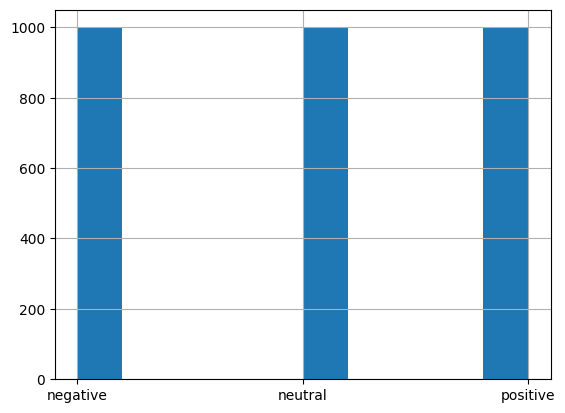

In [7]:
reviews['Sentiment'].hist()

In [8]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

# add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

In [10]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN + ' ' + reviews['Sentiment'].astype(str)
reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN + ' ' + reviews['Summary'].astype(str)

In [11]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: Tasted old and smelled like dog food. I would suggest buying fresh kale chips at your local health food store.\nSentiment: negative',
 "Sentiment Task\nReview: I bought thinking it was capuccino but it is way too sweet for my taste. And diabetics should'nt have that much sugar. No more for me.\nSentiment: negative"]

In [13]:
print('Sentiment Task\nReview: Tasted old and smelled like dog food. I would suggest buying fresh kale chips at your local health food store.\nSentiment: negative')

Sentiment Task
Review: Tasted old and smelled like dog food. I would suggest buying fresh kale chips at your local health food store.
Sentiment: negative


In [12]:
reviews['summarize_text'].head(2).tolist()

['Summarize Task\nReview: Tasted old and smelled like dog food. I would suggest buying fresh kale chips at your local health food store.\nSummarize: Not so great...',
 "Summarize Task\nReview: I bought thinking it was capuccino but it is way too sweet for my taste. And diabetics should'nt have that much sugar. No more for me.\nSummarize: Not as expected"]

In [14]:
print('Summarize Task\nReview: Tasted old and smelled like dog food. I would suggest buying fresh kale chips at your local health food store.\nSummarize: Not so great...')

Summarize Task
Review: Tasted old and smelled like dog food. I would suggest buying fresh kale chips at your local health food store.
Summarize: Not so great...


In [15]:
reviews = reviews.sample(frac = 1)

training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

# 6000 = 2 prompts per 1000 examples from the 3 sentiment groups
print(len(training_examples))

6000


In [17]:
multi_task_df = pd.DataFrame({'text': training_examples})

data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation = True)

data = data.map(preprocess, batched = True)

data = data.train_test_split(train_size = .8)

Map: 100%|██████████| 6000/6000 [00:00<00:00, 7860.78 examples/s]


In [18]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

In [19]:
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm = False)

In [21]:
training_args = TrainingArguments(
    output_dir = "./gpt2_multitask", # The output directory
    overwrite_output_dir = True, # Overwrite the content of the output directory
    num_train_epochs = 2, # Number of training epochs
    per_device_train_batch_size = 32, # Batch size for training
    per_device_eval_batch_size = 32, # Batch size for evaluation
    logging_steps = 50,
    load_best_model_at_end = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch'
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = data['train'],
    eval_dataset = data['test'],
    data_collator = data_collator
)

trainer.evaluate()

{'eval_loss': 5.029137134552002,
 'eval_runtime': 4.4562,
 'eval_samples_per_second': 269.287,
 'eval_steps_per_second': 8.527}

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.908300,2.752058
2,2.731200,2.702335


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=300, training_loss=2.9193159993489584, metrics={'train_runtime': 79.1069, 'train_samples_per_second': 121.355, 'train_steps_per_second': 3.792, 'total_flos': 137172628537344.0, 'train_loss': 2.9193159993489584, 'epoch': 2.0})

In [26]:
trainer.evaluate()

{'eval_loss': 2.7023346424102783,
 'eval_runtime': 2.7575,
 'eval_samples_per_second': 435.173,
 'eval_steps_per_second': 13.78,
 'epoch': 2.0}

In [27]:
trainer.save_model()

In [28]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model = loaded_model, tokenizer = tokenizer)

In [29]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
negative
Lindor Truffles


33

In [30]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [31]:
print(sentiment_text_sample)

Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment:


In [32]:
print(summarize_text_sample)

Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize:


In [33]:
for generated_text in generator(sentiment_text_sample, num_return_sequences = 1, max_length = num_tokens + 1):
    print(generated_text['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment: negative


/home/randi_eka/anaconda3/envs/huggingface/lib/python3.10/site-packages/transformers/generation/utils.py:1363: UserWarning: Input length of input_ids is 42, but `max_length` is set to 34. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


In [34]:
for generated_text in generator(summarize_text_sample, num_return_sequences = 3, max_length = num_tokens + 20):
    print(generated_text['generated_text'])
    print('-----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize: Tried Truffles on Amazon, but
-----
Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize: Tastes like the whole package. St
-----
Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize: Tastes like melted. Nothing happened.
-----


In [40]:
generator = pipeline('text-generation', model = GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer = tokenizer)

In [41]:
for generated_text in generator(sentiment_text_sample, num_return_sequences = 5, max_length = num_tokens + 1):
    print(generated_text['generated_text'])
    print('-----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment: One
-----
Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment: Received
-----
Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment: On
-----
Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment: Received
-----
Sentiment Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Sentiment: Received
-----


In [42]:
for generated_text in generator(summarize_text_sample, num_return_sequences = 3, max_length = num_tokens + 20):
    print(generated_text['generated_text'])
    print('-----')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize: In the end, I'm pretty disgusted by
-----
Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize: Didn't want to buy the chocolate until later
-----
Summarize Task
Review: Received Lindor Truffles and it was all melted. It was a total mess. Had to dump the whole box. Will not buy candy online again.
Summarize: I purchased a few last Thursday and received a
-----
